## Mengimpor Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import os

## Memuat Audio

In [2]:
file_path = os.path.join(os.getcwd(), 'data', 'ImperialMarch60.wav')

In [11]:
with wave.open(file_path, 'r') as wav_file:
    n_channels = wav_file.getnchannels()
    sampwidth = wav_file.getsampwidth()
    framerate = wav_file.getframerate()
    n_frames = wav_file.getnframes()
    audio_content = wav_file.readframes(n_frames)
    audio_data = np.frombuffer(audio_content, dtype=np.int16)
    
    if n_channels > 1:
        audio_data = audio_data.reshape(-1, n_channels)

In [12]:
# trim audio_data from 0 to 30 karena bagian akhir audio memiliki amplitude yang kecil
start_time = 0
end_time = 30

start_sample = int(start_time * framerate)
end_sample = int(end_time * framerate)

audio_data = audio_data[start_sample:end_sample]

## Normalisasi Audio

### Mengukur Amplitudo Maksimum

In [20]:
max_val = np.iinfo(np.int16).max
print(f"Max value: {max_val}")

Max value: 32767


Kode `max_val = np.iinfo(np.int16).max` melakukan hal berikut:

- **`np.iinfo(np.int16)`**: Bagian kode ini menggunakan fungsi `numpy.iinfo`, yaitu kelas yang memberikan batasan mesin untuk tipe integer. Argumen `np.int16` menetapkan bahwa kita tertarik pada properti tipe integer 16-bit.

- **`.max`**: Atribut kelas `iinfo` ini mengembalikan nilai maksimum yang dapat direpresentasikan untuk tipe integer tertentu, yang dalam hal ini adalah `np.int16`.

Singkatnya, kode `max_val = np.iinfo(np.int16).max` memberikan nilai maksimum yang mungkin dapat diwakili oleh bilangan bulat 16-bit ke variabel `max_val`. Untuk `np.int16`, nilai maksimumnya adalah `32767`.

Nilai ini biasanya digunakan dalam pemrosesan audio saat menormalkan sinyal audio, karena nilai ini mewakili amplitudo maksimum yang dapat disimpan dalam sampel audio 16-bit.

### Menormalisasi

In [14]:
normalized_audio = audio_data / np.max(np.abs(audio_data)) * max_val
normalized_audio = normalized_audio.astype(np.int16)

### Penjelasan Langkah demi Langkah

 - `np.abs(audio_data)`: Menghitung nilai absolut setiap sampel dalam data audio. Hal ini dilakukan karena kita tertarik pada amplitudo puncak, terlepas dari apakah amplitudonya positif atau negatif.
 - `np.max(...)`: Menemukan nilai maksimum di antara nilai absolut ini. Nilai ini mewakili amplitudo tertinggi (secara absolut) dalam data audio.


 ``` python
 audio_data / np.max(np.abs(audio_data))
 ```
 - Ini membagi setiap sampel dalam array `audio_data` dengan nilai absolut maksimum yang dihitung pada langkah sebelumnya.
 - Hasilnya adalah amplitudo maksimum dalam larik `audio_data` diskalakan ke 1 (atau -1 jika nilai maksimumnya negatif), yang secara efektif menormalkan data audio ke kisaran -1 hingga 1.

 ``` python
 audio_data / np.max(np.abs(audio_data)) * max_val
 ```
 - `* max_val`: Mengalikan setiap sampel yang dinormalisasi dengan `max_val`, yaitu `32767` untuk audio 16-bit. Ini menskalakan nilai yang dinormalisasi hingga kisaran -32767 hingga 32767, yang merupakan rentang penuh nilai yang dapat diwakili oleh bilangan bulat 16-bit.

 ``` python
 normalized_audio.astype(np.int16)
 ```
 - `.astype(np.int16)`: Mengonversi nilai normalisasi skala menjadi bilangan bulat 16-bit. Langkah ini memastikan bahwa data audio berada dalam format yang benar untuk disimpan dalam file audio 16-bit standar.

Normalisasi memastikan bahwa sinyal audio menggunakan rentang dinamis penuh yang tersedia, yang dapat membantu untuk:
- Meningkatkan volume keseluruhan tanpa distorsi.
- Memastikan konsistensi volume di berbagai file audio.
- Mempersiapkan audio untuk langkah pemrosesan lebih lanjut yang mengasumsikan rentang amplitudo standar.

### Visualisasi

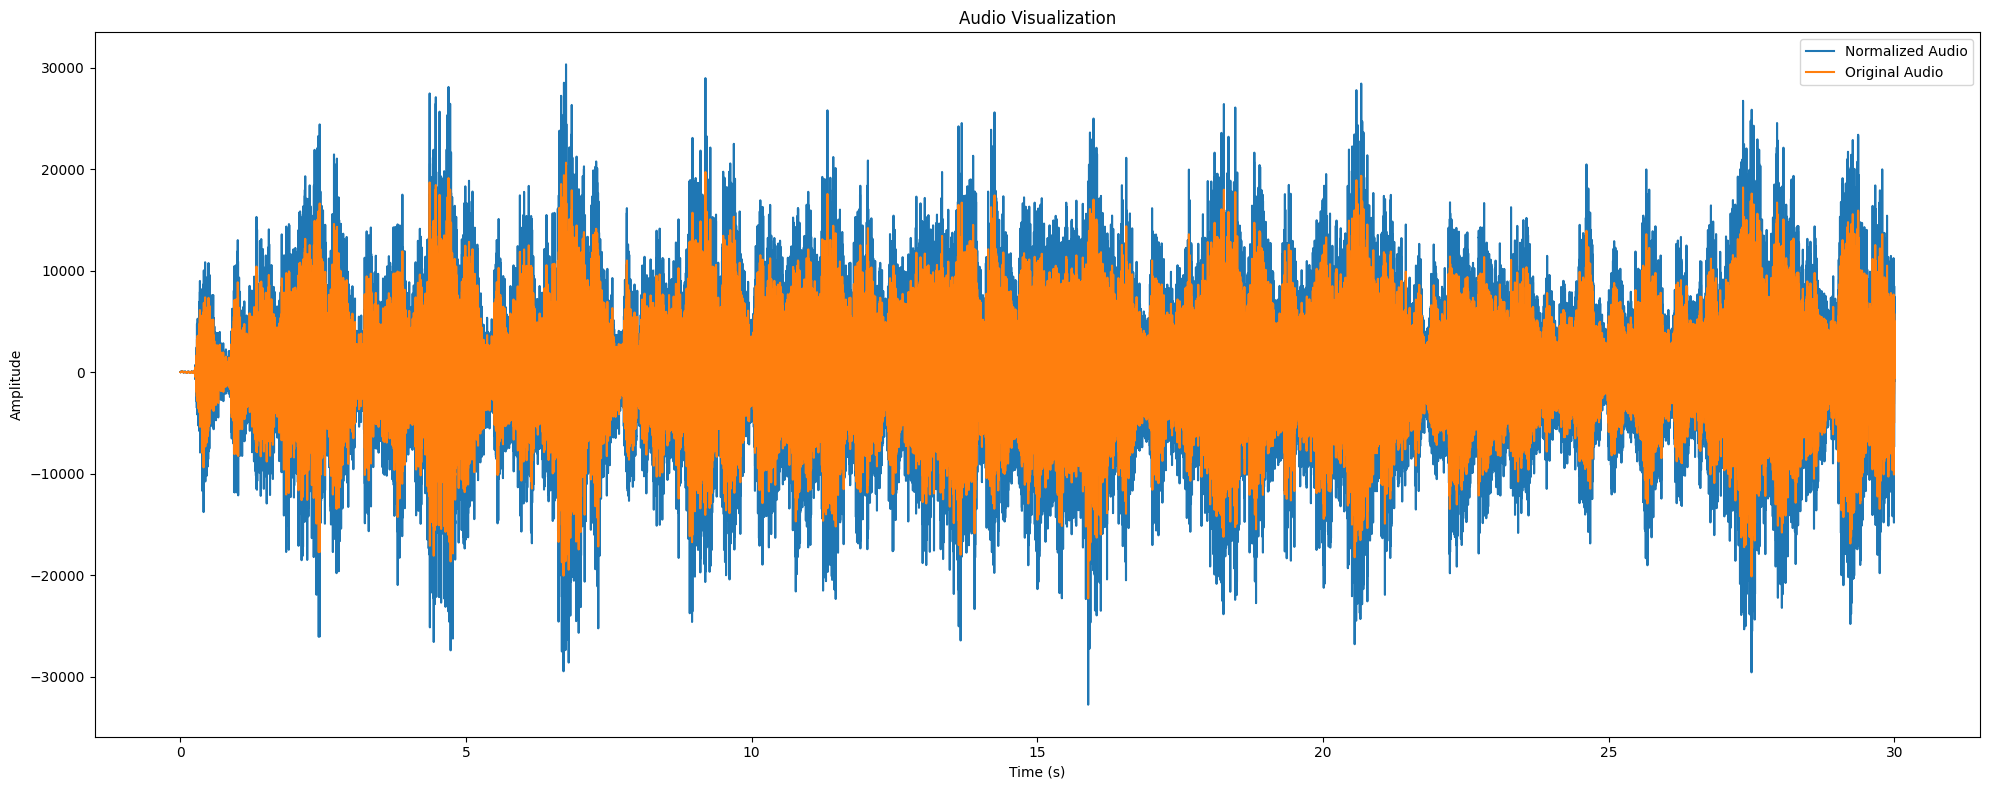

In [18]:
time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
# visualize in subplot
plt.figure(figsize=(20, 8))
plt.plot(time_axis, normalized_audio, label='Normalized Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()


### Menyimpan Audio

In [19]:
output_path = os.path.join(os.getcwd(), 'output', 'ImperialMarch60_norm.wav')
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with wave.open(output_path, 'w') as wav_file:
    wav_file.setnchannels(n_channels)
    wav_file.setsampwidth(sampwidth)
    wav_file.setframerate(framerate)
    wav_file.writeframes(normalized_audio.tobytes())

---

## Loudness and Dynamic Range Compression

### Loudness Level

In [22]:
loudness_factor = 1.5
adjusted_audio = audio_data * loudness_factor
adjusted_audio = np.clip(adjusted_audio, -max_val, max_val)

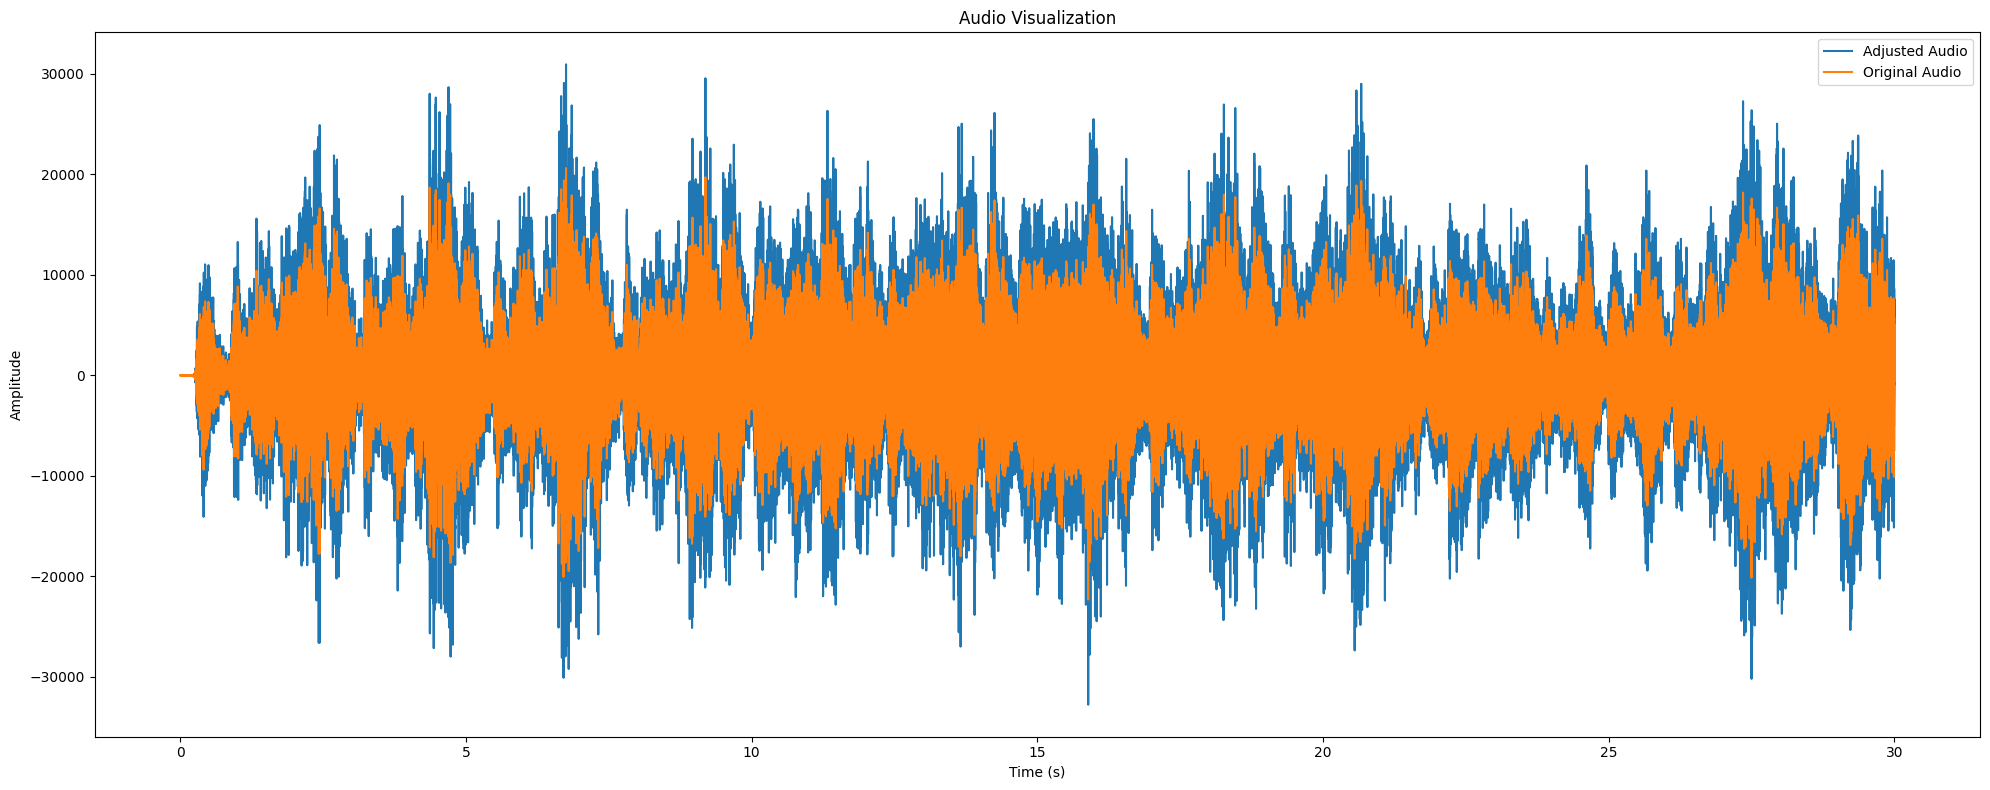

In [23]:
time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
plt.figure(figsize=(20, 8))
plt.plot(time_axis, adjusted_audio, label='Adjusted Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()


```python
loudness_factor = 1.5
```
- **loudness_factor**: Variabel ini mendefinisikan faktor yang digunakan untuk meningkatkan (atau mengurangi) keras suara dari audio. Faktor `1.5` berarti kita ingin meningkatkan keras suara sebesar 50%.

```python
adjusted_audio = audio_data * loudness_factor
```
- **audio_data * loudness_factor**: Setiap sampel dalam array `audio_data` dikalikan dengan `loudness_factor`. Operasi ini meningkatkan amplitudo sinyal audio, membuatnya lebih keras. Jika faktor tersebut kurang dari 1, maka akan mengurangi keras suara.

```python
adjusted_audio = np.clip(adjusted_audio, -max_val, max_val)
```
- **np.clip(adjusted_audio, -max_val, max_val)**: Fungsi `np.clip` membatasi nilai-nilai dalam array `adjusted_audio` agar berada dalam rentang `[-max_val, max_val]`, di mana `max_val` adalah nilai maksimum yang dapat direpresentasikan oleh integer 16-bit (`32767`). Langkah ini penting untuk mencegah distorsi akibat clipping, yang terjadi ketika nilai audio melebihi rentang maksimum yang dapat direpresentasikan.

- **np.linspace(0, len(audio_data) / framerate, num=len(audio_data))**: Menghasilkan array waktu yang terdistribusi secara linier dari `0` hingga durasi total audio (`len(audio_data) / framerate`). Array ini berfungsi sebagai sumbu waktu untuk memplot data audio.


### Dynamic Range Compression

In [33]:
threshold = max_val * 0.5
ratio = 4
compressed_audio = adjusted_audio.copy()

abs_audio_data = np.abs(compressed_audio)
mask = abs_audio_data > threshold

compressed_audio[mask] = threshold + (compressed_audio[mask] - threshold) / ratio
compressed_audio = np.clip(compressed_audio, -max_val, max_val)

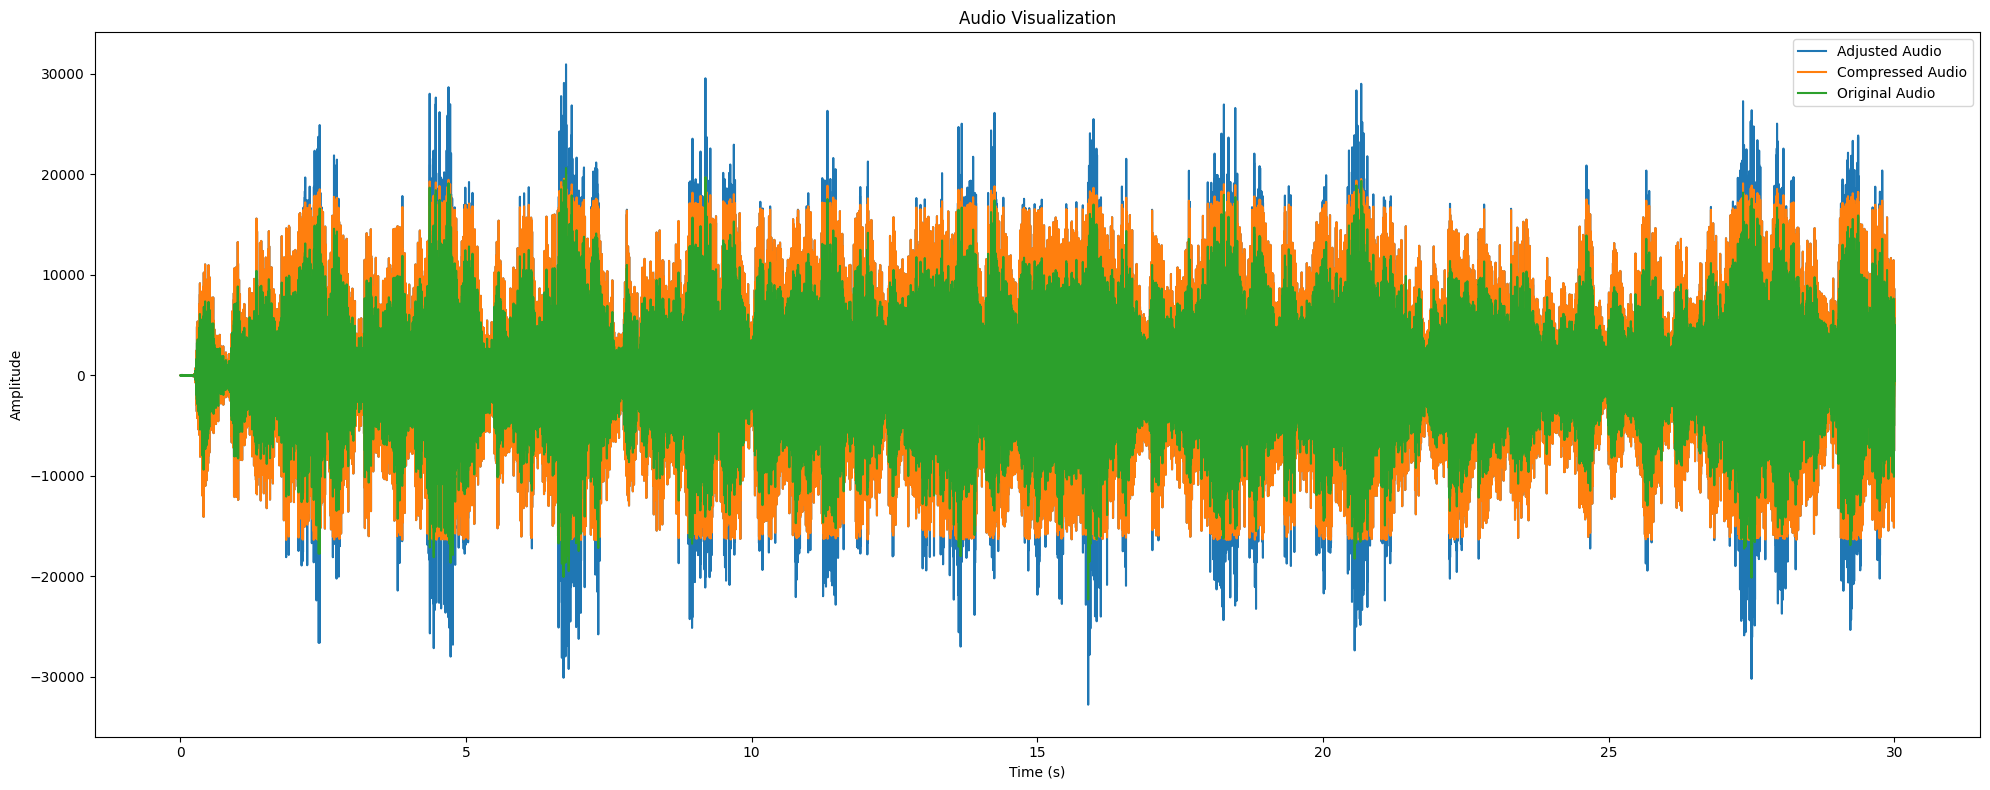

In [34]:
time_axis = np.linspace(0, len(audio_data) / framerate, num=len(audio_data))
plt.figure(figsize=(20, 8))
plt.plot(time_axis, adjusted_audio, label='Adjusted Audio')
plt.plot(time_axis, compressed_audio, label='Compressed Audio')
plt.plot(time_axis, audio_data, label='Original Audio')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.title('Audio Visualization')
plt.legend(); plt.tight_layout(); plt.show()

```python
threshold = max_val * 0.5
ratio = 4
compressed_audio = adjusted_audio.copy()
```

- **threshold = max_val * 0.5**: 
  - `max_val` adalah nilai maksimum yang dapat direpresentasikan oleh integer 16-bit (`32767`).
  - `threshold` menetapkan ambang batas kompresi, yaitu 50% dari `max_val`. Jadi, `threshold` adalah `32767 * 0.5 = 16383.5`.
  - Artinya, sinyal audio yang amplitudonya melebihi nilai ini akan dikompresi.
- **ratio = 4**: 
  - `ratio` menetapkan rasio kompresi, yaitu 4:1.
  - Ini berarti untuk setiap 4 dB yang melebihi ambang batas, hanya 1 dB yang akan dihasilkan setelah kompresi.
- **compressed_audio = adjusted_audio.copy()**: 
  - Membuat salinan dari `adjusted_audio` untuk memastikan kita tidak mengubah data asli saat melakukan kompresi.

```python
abs_audio_data = np.abs(compressed_audio)
mask = abs_audio_data > threshold
```

- **abs_audio_data = np.abs(compressed_audio)**:
  - Menghitung nilai absolut dari setiap sampel dalam `compressed_audio`.
  - Nilai absolut digunakan karena kita tertarik pada besar amplitudo tanpa memperhatikan tanda (positif atau negatif).
- **mask = abs_audio_data > threshold**:
  - Membuat array boolean (`mask`) yang memiliki nilai `True` untuk setiap sampel yang nilai absolutnya melebihi `threshold`.
  - `mask` ini akan digunakan untuk mengidentifikasi sampel yang perlu dikompresi.

```python
compressed_audio[mask] = threshold + (compressed_audio[mask] - threshold) / ratio
```

- **compressed_audio[mask]**:
  - Memilih sampel dalam `compressed_audio` yang memenuhi kondisi `mask` (nilai absolutnya lebih besar dari `threshold`).
- **threshold + (compressed_audio[mask] - threshold) / ratio**:
  - Untuk setiap sampel yang melebihi ambang batas, nilai baru dihitung dengan rumus:
    - Kurangi nilai sampel dengan `threshold`.
    - Bagilah hasil pengurangan dengan `ratio`.
    - Tambahkan `threshold` ke hasil pembagian untuk mendapatkan nilai yang dikompresi.
  - Proses ini mengurangi amplitudo sampel yang melebihi `threshold` sesuai dengan rasio kompresi yang ditentukan.

```python
compressed_audio = np.clip(compressed_audio, -max_val, max_val)
```

- **np.clip(compressed_audio, -max_val, max_val)**:
  - Fungsi `np.clip` membatasi nilai-nilai dalam `compressed_audio` agar berada dalam rentang `[-max_val, max_val]`.
  - Langkah ini memastikan bahwa tidak ada nilai yang melebihi batas yang dapat direpresentasikan oleh integer 16-bit (`-32767` hingga `32767`).
  - Ini penting untuk mencegah distorsi akibat clipping, yang dapat terjadi jika nilai melebihi rentang maksimum yang dapat direpresentasikan.

In [35]:
# Save the compressed audio
output_path_compressed = os.path.join(os.getcwd(), 'output', 'ImperialMarch60_comp.wav')
os.makedirs(os.path.dirname(output_path_compressed), exist_ok=True)

with wave.open(output_path_compressed, 'w') as wav_file:
    wav_file.setnchannels(n_channels)
    wav_file.setsampwidth(sampwidth)
    wav_file.setframerate(framerate)
    wav_file.writeframes(compressed_audio.tobytes())

---

## Tugas: `ho1`
3. Pada hands-on di atas, kita menggunakan `max_val = np.iinfo(np.int16).max` untuk menentukan nilai maksimum yang dapat diwakili oleh 16-bit signed integer. Hal ini berlaku untuk audio dengan bit depth 16-bit. Namun, pada praktiknya, audio juga dapat direkam dengan bit depth yang berbeda, misalnya 8-bit, 24-bit, atau 32-bit.
    - Apa pengaruhnya jika sebuah audio direkam dengan bit depth yang lebih besar? Buktikan dengan sebuah eksperimen. File audio 24bit, 44100Hz dapat diunduh [di sini](https://msbtechnology.com/support/bit-perfect-testing/). Di web tersebut juga terdapat audio 16bit, 44100Hz.
    - Dengan menaikkan amplitudenya (menggunakan faktor yang sama), buktikan bahwa audio 24-bit memiliki dynamic range yang lebih besar dibandingkan audio 16-bit.

4.  Jelaskan apa yang terjadi pada audio compression dengan cara berikut:
    - Dengan handphone / laptop anda, rekamlah sebuah audio sepanjang 20 detik
    - Di bagian awal, bicaralah dengan suara pelan, ucapkan nama lengkap anda sendiri
    - Beri jeda 2-3 detik, lalu bicaralah dengan suara keras, ucapkan nama lengkap anda sendiri
    - Lakukanlah kompresi terhadap audio, dan buktikan dengan visualisasi bahwa audio tersebut telah terkompresi. Bandingkan waveform sebelum di proses dan sesudah di proses. Jelaskan apa yang terjadi pada bagian yang pelan dan bagian yang keras dari audio tersebut.

### Ketentuan Penamaan File
```
nim_ho1.ipynb
```

> Saya sudah mendapatkan akses ke server [MOSS Stanford](https://theory.stanford.edu/~aiken/moss/) untuk menggunakan sistem mereka dalam mata kuliah ini untuk mendeteksi code yang "plagiat". Untuk menjamin bahwa code anda tidak terindikasi plagiarisme, silahkan gunakan nama variabel / parameter / dan konfigurasi yang unik dan tidak copy paste. Dan yang terpenting, berusahalah bekerja sendiri. Jika mendapat bantuan baik dari manusia maupun AI / web, segera cantumkan dalam bagian terakhir `ipynb` anda.

### Pengumpulan
- Unggah `.ipynb` ke repositori anda.
- Paste link dari file ke google form pengumpulan tugas
- Export `.ipynb` menjadi `.pdf` dan unggah juga ke google form

Link yang di paste harus mirip dengan format berikut:
```
https://github.com/<username>/<kode_mk>/blob/master/<nim_ho1>.ipynb
```

- *Pastikan repo anda bersifat privat dan anda telah mengundang dosen pengampu ke repositori anda*
- Seluruh tugas untuk ho1 digabung dalam satu file notebook `.ipynb`
- Berikan penjelasan yang sedetail-detailnya untuk setiap bagian eksperimen yang anda lakukan

